In [10]:
# !python -m pip install numpy==1.22.3

In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from itertools import product
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pandas'

In [ ]:
combined = pd.read_csv("Combined_Dataset.csv", index_col = "date")

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
y_var = 'delta_cases_per_capita'

In [ ]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [ ]:
# Initialise training and test data
train_data = combined.iloc[:int(2/3*len(combined))]
test_data = combined.iloc[int(2/3*len(combined)):]

In [ ]:
train_data.columns

Index(['delta_deaths_per_capita', 'delta_cases_per_capita',
       'delta_deaths_per_capita.l1', 'delta_cases_per_capita.l1',
       'log_new_vaccines_per_capita', 'log_new_people_vaccinated_per_capita',
       'delta_cases_per_capita_United Kingdom',
       'delta_deaths_per_capita_United Kingdom',
       'delta_cases_per_capita_Germany', 'delta_deaths_per_capita_Germany',
       'delta_cases_per_capita_France', 'delta_deaths_per_capita_France',
       'full_lockdown', 'full_lockdown.l30', 'full_lockdown.l45', 'max_tp',
       'min_tp', 'rain', 'humidity', 'day_of_the_week', 'season', 'trend'],
      dtype='object')

In [ ]:
x_columns_to_scale = np.arange(4, 12) # from log_new_vaccines_per_capita to delta_deaths_per_capita_France

In [ ]:
x_columns_not_to_scale = ['delta_cases_per_capita.l1', 'full_lockdown', 'full_lockdown.l30', 'full_lockdown.l30', 'max_tp', 'min_tp', 'rain', 'humidity', 'day_of_the_week', 'season', 'trend']

In [ ]:
scaled_x_train = x_scaler.fit_transform(train_data.iloc[:, x_columns_to_scale])
scaled_x_train = pd.DataFrame(scaled_x_train, columns = train_data.columns[x_columns_to_scale])

In [ ]:
scaled_y_train = y_scaler.fit_transform(np.array(train_data.iloc[:,train_data.columns.get_loc(y_var)]).reshape(-1,1))
scaled_y_train = pd.DataFrame(scaled_y_train, columns = ['delta_cases_per_capita'])

x_train = scaled_x_train.values
y_train = scaled_y_train.values

**Establish Data in Tensors (batch size = 30)**

In [ ]:
tensor_size = 30
dim = 8

In [ ]:
final_x_train = []
final_y_train = []

for i in range(tensor_size, len(y_train)):
    final_x_train.append(x_train[i-tensor_size:i])
    final_y_train.append(y_train[i])

final_x_train = np.array(final_x_train)
final_y_train = np.array(final_y_train)

final_x_train = np.reshape(final_x_train, (final_x_train.shape[0], final_x_train.shape[1], dim))

# Could do cross-validation here.

In [ ]:
model = Sequential()
# Adding in the LSTM Layers including dropout layers for regularisation
model.add(LSTM(units = 1, return_sequences = True, input_shape = (final_x_train.shape[1], dim)))
model.add(Dropout(0.2))

model.add(LSTM(units = 1, return_sequences = True, input_shape = (final_x_train.shape[1], dim)))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(final_x_train, final_y_train, epochs = 100, batch_size = 32)

Epoch 1/100
12/12 [==============================] - 4s 22ms/step - loss: 0.0563
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0354
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0240
Epoch 4/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0184
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0165
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0158
Epoch 7/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0153
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0154
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0150
Epoch 10/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0149
Epoch 11/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0146
Epoch 12/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0145
Epoch 13/100
12/12 [=====

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 1)             40        
                                                                 
 dropout_2 (Dropout)         (None, 30, 1)             0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 1)             12        
                                                                 
 dropout_3 (Dropout)         (None, 30, 1)             0         
                                                                 
 dense_1 (Dense)             (None, 30, 1)             2         
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_test = test_data.iloc[:, x_columns_to_scale]
y_test = test_data.iloc[:, test_data.columns.get_loc(y_var)]

In [ ]:
scaled_test = x_scaler.transform(x_test)

final_x_test = []
for i in range(tensor_size, len(y_test)):
    final_x_test.append(scaled_test[i-tensor_size:i])

final_x_test = np.array(final_x_test)

final_x_test = np.reshape(final_x_test, (final_x_test.shape[0], final_x_test.shape[1], dim))

In [ ]:
predictions = model.predict(final_x_test)

In [ ]:
preds = {}
for i in range(tensor_size):
    preds[i] = predictions[:,:, 0][:, i].reshape(-1, 1)

In [ ]:
prediction_df = pd.DataFrame(preds[0])
for i in range(1, 30):
    prediction_df[i] = preds[i]

In [ ]:
preds = predictions[:,:, 0][:, 0].reshape(-1, 1)

In [ ]:
predictions = y_scaler.inverse_transform(prediction_df)

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 KB 1.6 MB/s eta 0:00:00


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

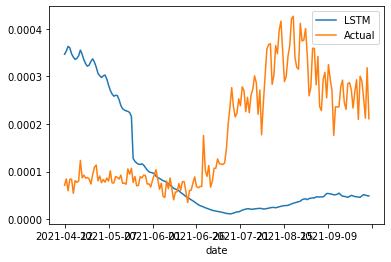

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(predictions.mean(axis = 1)).plot(ax = ax, label = "LSTM")

test_data['delta_cases_per_capita'].loc[test_data.index].shift(-1).iloc[:-tensor_size].plot(ax = ax, label = "Actual")
ax.legend(['LSTM', "Actual"])

In [ ]:
import shap